In [3]:
import os
import numpy as np
import re

os.environ["http_proxy"] = "http://127.0.0.1:7890"
os.environ["https_proxy"] = "http://127.0.0.1:7890"
os.environ["OPENAI_API_KEY"] = "sk-ysz3no5my9Txp0ctyw3wCtBPbkAU2RvUVltqfhyYt0ezEBUM"
os.environ["OPENAI_BASE_URL"] = "https://api.key77qiqi.cn/v1"

from openai import OpenAI
import json

In [4]:
import json
from collections import defaultdict

# 文件路径
file_path = '/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/dataset/python/train.jsonl'

# 初始化一个字典来存储每个 repo 的数据
repo_dict = defaultdict(int)
total_data_count = 0  # 总数据条数

# 读取 jsonl 文件
with open(file_path, 'r') as f:
    for line in f:
        data = json.loads(line.strip())
        repo = data.get('repo', 'Unknown')  # 获取 repo 字段
        repo_dict[repo] += 1  # 统计 repo 出现的次数
        total_data_count += 1

# 按出现次数从多到少排序
sorted_repo = sorted(repo_dict.items(), key=lambda x: x[1], reverse=True)

In [5]:
import json
# 文件路径
file_path = '/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/dataset/python/train.jsonl'

# 存储所有数据的列表
train_data = []

# 读取 JSONL 文件中的所有数据
with open(file_path, 'r') as f:
    for line in f:
        train_data.append(json.loads(line.strip()))


In [6]:
# 打印每个类别的数量
for repo, count in sorted_repo:
    print(f'Repo: {repo}, Count: {count}')

# 打印总类别数量
total_categories = len(repo_dict)
print(f'总类别数量: {total_categories}')

Repo: saltstack/salt, Count: 7016
Repo: mitsei/dlkit, Count: 1629
Repo: google/grr, Count: 1404
Repo: bcbio/bcbio-nextgen, Count: 1369
Repo: materialsproject/pymatgen, Count: 1290
Repo: tensorflow/tensor2tensor, Count: 1217
Repo: iotile/coretools, Count: 1212
Repo: pandas-dev/pandas, Count: 1134
Repo: spyder-ide/spyder, Count: 1033
Repo: pypa/pipenv, Count: 1007
Repo: apple/turicreate, Count: 994
Repo: gem/oq-engine, Count: 931
Repo: pantsbuild/pants, Count: 915
Repo: log2timeline/plaso, Count: 911
Repo: googleapis/google-cloud-python, Count: 904
Repo: inasafe/inasafe, Count: 852
Repo: gwastro/pycbc, Count: 794
Repo: apache/incubator-mxnet, Count: 786
Repo: senaite/senaite.core, Count: 742
Repo: sorgerlab/indra, Count: 720
Repo: tanghaibao/jcvi, Count: 715
Repo: openstack/networking-cisco, Count: 620
Repo: twilio/twilio-python, Count: 607
Repo: fabioz/PyDev.Debugger, Count: 603
Repo: angr/angr, Count: 590
Repo: DLR-RM/RAFCON, Count: 588
Repo: manns/pyspread, Count: 588
Repo: mikedh/tri

In [4]:
# 计算数据数量大于阈值的库包含的总数据条目数
threshold = 9
total_data_above_threshold = sum(count for repo, count in sorted_repo if count > threshold)
print(f'数据数量大于 {threshold} 的库共包含: {total_data_above_threshold} 条数据')

数据数量大于 9 的库共包含: 227965 条数据


In [5]:
total_data_above_threshold / total_data_count

0.9052696370423319

In [20]:
# 文件路径
file_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/tokenized_code_tokens_train.json'

# 读取 JSON 文件
with open(file_path, 'r') as f:
    code_tokens_strs = json.load(f)

# 文件路径
nl_file_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/tokenized_comment_tokens_train.json'

# 读取 JSON 文件
with open(nl_file_path, 'r') as f:
    nl_tokens_strs = json.load(f)

# 现在 code_tokens_strs 变量中包含了从 JSON 文件读取的数据
print(len(code_tokens_strs))  # 可以查看加载的数据
print(len(nl_tokens_strs))  # 可以查看加载的数据

251820
251820


In [7]:
# Load the embeddings from the stored numpy file
code_token_output_path = "/home/yiming/cophi/training_dynamic/gcb_tokens_temp/train_code_cls_token_pt.npy"
all_embeddings = np.load(code_token_output_path)

print(all_embeddings.shape) 

(251820, 768)


In [8]:
import random

# Assuming `all_embeddings` has shape [N, D]
num_samples = 10000
total_samples = all_embeddings.shape[0]

# Randomly select 10,000 indices
random_indices = random.sample(range(total_samples), num_samples)

In [9]:
# Extract the selected embeddings
selected_embeddings = all_embeddings[random_indices, :]

In [10]:
import torch
import matplotlib.pyplot as plt

def initialize_centroids(X, k):
    # 随机选择k个初始聚类中心
    indices = torch.randperm(X.size(0))[:k]
    return X[indices]

def compute_distances(X, centroids):
    # 计算每个点到每个聚类中心的欧氏距离
    distances = torch.cdist(X, centroids, p=2)  # 使用L2范数
    return distances

def kmeans(X, k, num_iters=100):
    # 初始化聚类中心
    centroids = initialize_centroids(X, k)
    
    for _ in range(num_iters):
        # 计算距离并为每个点分配最近的聚类中心
        distances = compute_distances(X, centroids)
        labels = distances.argmin(dim=1)
        
        # 重新计算聚类中心
        new_centroids = torch.stack([X[labels == i].mean(dim=0) for i in range(k)])
        
        # 检查是否有空聚类
        nan_mask = torch.isnan(new_centroids)
        new_centroids[nan_mask] = centroids[nan_mask]  # 如果出现空聚类，保持旧的中心

        # 更新聚类中心
        centroids = new_centroids
    
    # 返回最终的聚类中心和每个点的标签
    return centroids, labels

/home/yiming/anaconda3/envs/visualizer/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
selected_embeddings_tensor = torch.tensor(selected_embeddings).to('cuda')

Clustering with 1 clusters...
Clustering with 2 clusters...
Clustering with 3 clusters...
Clustering with 4 clusters...
Clustering with 5 clusters...
Clustering with 6 clusters...
Clustering with 7 clusters...
Clustering with 8 clusters...
Clustering with 9 clusters...
Clustering with 10 clusters...
Clustering with 11 clusters...
Clustering with 12 clusters...
Clustering with 13 clusters...
Clustering with 14 clusters...
Clustering with 15 clusters...
Clustering with 16 clusters...
Clustering with 17 clusters...
Clustering with 18 clusters...
Clustering with 19 clusters...
Clustering with 20 clusters...
Clustering with 21 clusters...
Clustering with 22 clusters...
Clustering with 23 clusters...
Clustering with 24 clusters...
Clustering with 25 clusters...
Clustering with 26 clusters...
Clustering with 27 clusters...
Clustering with 28 clusters...
Clustering with 29 clusters...
Clustering with 30 clusters...
Clustering with 31 clusters...
Clustering with 32 clusters...
Clustering with 3

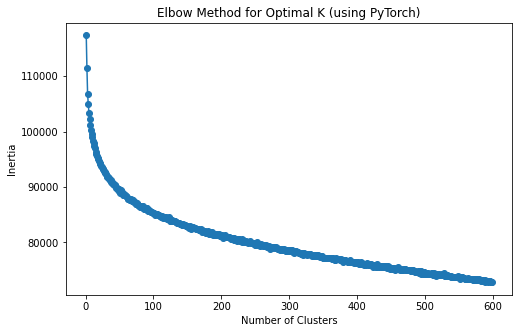

In [12]:

# 定义聚类数量范围
cluster_range = range(1, 600)
inertia = []

# 对每个聚类数量进行KMeans聚类并计算inertia
for k in cluster_range:
    print(f"Clustering with {k} clusters...")
    centroids, labels = kmeans(selected_embeddings_tensor, k)
    
    # 计算 inertia（簇内平方距离的总和）
    distances = compute_distances(selected_embeddings_tensor, centroids)
    closest_distances = distances.min(dim=1)[0]
    inertia.append(closest_distances.pow(2).sum().item())

# 绘制inertia以可视化肘部法则
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K (using PyTorch)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

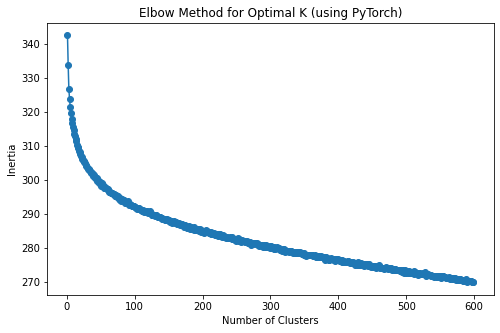

In [13]:
# 计算 inertia 列表中每个元素的平方根
import math

inertia_rooted = [math.sqrt(value) for value in inertia]

# 绘制inertia以可视化肘部法则
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia_rooted, marker='o')
plt.title('Elbow Method for Optimal K (using PyTorch)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [329]:
import torch
import numpy as np

# 定义使用的聚类数量，替换为肘部法则找到的最佳聚类数
optimal_k = 165  # 替换为肘部法则找到的最佳值

# 假设 selected_embeddings 已经在 GPU 上作为一个 PyTorch Tensor
# 使用之前实现的 KMeans 代码
centroids, labels = kmeans(selected_embeddings_tensor, optimal_k)

# 将聚类中心从 PyTorch tensor 转为 NumPy数组（因为我们之后要用到NumPy函数）
centroids_np = centroids.cpu().numpy()  # 从 GPU 移到 CPU 并转为 NumPy 数组


In [330]:
# 将数据从 GPU Tensor 转为 NumPy 数组以便使用 NumPy 函数
selected_embeddings_np = selected_embeddings_tensor.cpu().numpy()

# 存储每个聚类中心的最相似点
closest_data_points = []

# 对每个聚类中心进行处理
for center in centroids_np:
    # 计算每个样本到该聚类中心的欧氏距离
    distances = np.linalg.norm(selected_embeddings_np - center, axis=1)
    
    # 找到距离最小的样本的索引
    closest_index = np.argmin(distances)
    
    # 将该索引添加到列表中
    closest_data_points.append(closest_index)

# 打印出与每个聚类中心最相似的样本索引
print("Indices of data points closest to cluster centers:", closest_data_points)


Indices of data points closest to cluster centers: [7350, 7073, 5465, 3001, 4820, 4383, 7246, 3173, 9112, 3071, 6266, 811, 1430, 1819, 5671, 5145, 3944, 7728, 816, 6787, 4152, 2750, 4706, 1416, 9327, 5344, 3950, 8025, 5831, 3705, 575, 2058, 2184, 5508, 4079, 5828, 9717, 6565, 7766, 5698, 6855, 6265, 7728, 8253, 9221, 5331, 7823, 977, 5555, 3631, 4272, 1599, 904, 3482, 7913, 7408, 3456, 7278, 6588, 5103, 6169, 8534, 4775, 4239, 3454, 1995, 9146, 6124, 4881, 6686, 5154, 8014, 8141, 5331, 8998, 1416, 8715, 233, 152, 3376, 8141, 6212, 2876, 9339, 1516, 4320, 9912, 6095, 1306, 916, 1154, 1140, 930, 5936, 3105, 3613, 1104, 2782, 6941, 5397, 1759, 7450, 1879, 8875, 755, 8900, 82, 4300, 6873, 8907, 991, 465, 5678, 4381, 5059, 6286, 6588, 9459, 2901, 8170, 7658, 8570, 5799, 6855, 5047, 6733, 2446, 576, 4179, 3329, 1191, 7432, 5810, 7601, 1975, 645, 9179, 9027, 5622, 8466, 7930, 9768, 6517, 9242, 1904, 4235, 9913, 4348, 7943, 4739, 5357, 9146, 6730, 3613, 3628, 2633, 8379, 9244, 3466, 7009, 6722

In [331]:
import torch
import numpy as np

# selected_embeddings_tensor: 是所有样本的嵌入（已经在GPU上）
# centroids: 是每个聚类的中心点（PyTorch tensor, 在GPU上）

# 计算每个样本点到所有聚类中心的距离
# 这里的返回矩阵形状是 (num_samples, num_clusters)
distances_to_centroids = torch.cdist(selected_embeddings_tensor, centroids, p=2)

# 找到每个样本距离最近的聚类中心及其索引
min_distances, closest_centroids = torch.min(distances_to_centroids, dim=1)

# 将结果转回CPU，并转换为NumPy格式
min_distances_np = min_distances.cpu().numpy()  # 距离最近的距离
closest_centroids_np = closest_centroids.cpu().numpy()  # 所属的聚类类别

# 打印结果
print("每个样本的最近距离: ", min_distances_np)
print("每个样本所属的类别: ", closest_centroids_np)


每个样本的最近距离:  [2.7825048 2.0659328 2.717472  ... 3.5699112 3.556831  2.603764 ]
每个样本所属的类别:  [ 75  39 134 ...  85 162 132]


In [5]:
closest_data_points = [7350, 7073, 5465, 3001, 4820, 4383, 7246, 3173, 9112, 3071, 6266, 811, 1430, 1819, 5671, 5145, 3944, 7728, 816, 6787, 4152, 2750, 4706, 1416, 9327, 5344, 3950, 8025, 5831, 3705, 575, 2058, 2184, 5508, 4079, 5828, 9717, 6565, 7766, 5698, 6855, 6265, 7728, 8253, 9221, 5331, 7823, 977, 5555, 3631, 4272, 1599, 904, 3482, 7913, 7408, 3456, 7278, 6588, 5103, 6169, 8534, 4775, 4239, 3454, 1995, 9146, 6124, 4881, 6686, 5154, 8014, 8141, 5331, 8998, 1416, 8715, 233, 152, 3376, 8141, 6212, 2876, 9339, 1516, 4320, 9912, 6095, 1306, 916, 1154, 1140, 930, 5936, 3105, 3613, 1104, 2782, 6941, 5397, 1759, 7450, 1879, 8875, 755, 8900, 82, 4300, 6873, 8907, 991, 465, 5678, 4381, 5059, 6286, 6588, 9459, 2901, 8170, 7658, 8570, 5799, 6855, 5047, 6733, 2446, 576, 4179, 3329, 1191, 7432, 5810, 7601, 1975, 645, 9179, 9027, 5622, 8466, 7930, 9768, 6517, 9242, 1904, 4235, 9913, 4348, 7943, 4739, 5357, 9146, 6730, 3613, 3628, 2633, 8379, 9244, 3466, 7009, 6722, 5151, 4393, 4456, 4348]

In [8]:
len(closest_data_points[65:])

100

In [14]:
random_indices[closest_data_points[65:]]

array([195657, 124929, 167340, 142843, 132394, 231356,  16694,  80981,
        13788, 241018, 196599,  63357, 198172,    564, 169780,  80981,
       248074, 229106,  55909,  64423, 203649, 151241, 242029, 147166,
       227920,  65620,  84958,  61819,  43656,  44787, 195366, 215734,
       245591,  61340, 208447,  10662, 222743,  41532, 212745,  77277,
        73200,  62575, 169496,   2177, 113825, 166047, 208043,  14062,
       240403, 164371, 202155, 108025, 147687, 113803, 224695,  59991,
        81994, 112556, 121017, 142339,  41952, 248678, 167917,  58068,
       232593, 192571, 165040, 146448, 207326, 232105, 181438, 231286,
       194065, 194140, 111559,  44082, 205798, 227006,  44817, 155315,
       169723, 185779, 145857,  21738, 199547, 172582, 124929, 190168,
       195366,  15834, 249892,  84597,  73565, 194256,  57744,  37416,
       134576, 226256,   2892, 145857])

In [28]:
# 将距离和类别组合到一起，创建一个字典来存储结果
sample_assignment = {
    'sample_index': list(range(len(min_distances_np))),
    'closest_centroid': closest_centroids_np,
    'distance_to_centroid': min_distances_np
}

# 也可以将结果保存为NumPy文件
np.save('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/sample_assignments.npy', sample_assignment)


In [29]:
np.save('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/random_indices.npy', random_indices)

In [8]:
sample_assignment = np.load('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/sample_assignments.npy', allow_pickle=True)

In [14]:
import numpy as np
random_indices = np.load('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/random_indices.npy')

In [12]:
sample_assignment

array({'sample_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 2

In [8]:
random_indices[closest_data_points[:100]]

array([231476,  57129, 100828, 139587, 121205, 140530, 161936,  28475,
       123668,  59621, 100016,   6043, 130545,   6418, 162126, 206875,
        38822,  75717, 248674, 100190, 136389, 214800, 196044, 196599,
        61418, 246579, 155504,  59032, 250209, 221605, 102205, 246641,
       239125, 224239,  84966,  11810,   7167, 215798, 136854, 147839,
       121017,  82033,  75717,  53226, 135660,  13788, 235527, 219029,
       136499, 247013,  86401, 172765, 123339,  17568,  95981,  64086,
       109834,  61215, 108025,  14603,  98406, 150475, 135245, 137807,
       132464, 195657, 124929, 167340, 142843, 132394, 231356,  16694,
        80981,  13788, 241018, 196599,  63357, 198172,    564, 169780,
        80981, 248074, 229106,  55909,  64423, 203649, 151241, 242029,
       147166, 227920,  65620,  84958,  61819,  43656,  44787, 195366,
       215734, 245591,  61340, 208447])

In [9]:
labeling_index = random_indices[closest_data_points[:65]]

In [34]:
num = 0
for i in range(len(min_distances_np)):
    if min_distances_np[i] > 4:
        num += 1
num


76

In [15]:
input_path = "/home/yiming/cophi/training_dynamic/NL-code-search-Adv/model/codebert/token_alignment/label_human_teacher.jsonl"
idx_list = []
match_list = []

with open(input_path, 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip().rstrip(',')  # 去除行末的逗号
        json_obj = json.loads(line)
        idx_list.append(json_obj['idx'])
        match_list.append(json_obj['match'])

In [16]:
# 使用集合操作来加速从 random_indices 中移除 idx_list 中的索引
unlabeled_indices = list(set(range(len(train_data))) - set(idx_list))
len(unlabeled_indices)

251599

In [17]:
cluster_centers = all_embeddings[idx_list]

# 提取未标注样本的嵌入
unlabeled_embeddings = all_embeddings[unlabeled_indices]

# 初始化用于存储每个未标注样本的最小距离和最近的聚类中心索引
min_distances = []
closest_centers = []

# 逐个计算未标注样本到所有聚类中心的距离，保留最小值
for unlabel_i in unlabeled_indices:
    # 计算当前未标注样本到所有聚类中心的距离
    distances_to_centers = np.linalg.norm(all_embeddings[unlabel_i] - cluster_centers, axis=1)
    # 找到最小距离和对应的聚类中心索引
    min_distance = distances_to_centers.min()
    closest_center = distances_to_centers.argmin()
    
    # 保存最小距离和对应聚类中心
    min_distances.append(min_distance)
    closest_centers.append(closest_center)
    if unlabel_i % 10000 == 0:
        print(unlabel_i)

# 定义距离阈值
distance_threshold = 2.7  # 这个值可以根据具体需求进行调整

# 筛选出距离小于阈值的样本索引
auto_label_indices = [unlabeled_indices[i] for i in range(len(unlabeled_indices)) if min_distances[i] < distance_threshold]
closest_teachers = [closest_centers[i] for i in range(len(unlabeled_indices)) if min_distances[i] < distance_threshold]

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000


In [9]:
# import numpy as np

# # 提取聚类中心的嵌入
# cluster_centers = all_embeddings[idx_list]

# # 提取未标注样本的嵌入
# unlabeled_embeddings = all_embeddings[unlabeled_indices]

# # 计算所有未标注样本到所有聚类中心的距离
# distances = np.linalg.norm(unlabeled_embeddings[:, np.newaxis] - cluster_centers, axis=2)

# # 找到每个样本到最近的聚类中心的距离和对应聚类中心的索引
# min_distances = distances.min(axis=1)
# closest_centers = distances.argmin(axis=1)


In [10]:
# # 定义距离阈值
# distance_threshold = 3.5  # 这个值可以根据具体需求进行调整

# # 筛选出距离小于阈值的样本索引
# auto_label_indices = [unlabeled_indices[i] for i in range(len(unlabeled_indices)) if min_distances[i] < distance_threshold]
# closest_teachers = [closest_centers[i] for i in range(len(unlabeled_indices)) if min_distances[i] < distance_threshold]


In [13]:
# cannotlabeled_indices = list(set(random_indices) - set(auto_label_indices))
# len(cannotlabeled_indices)

5019

In [35]:
filtered_min_distance_indices = [min_distances[i] for i in range(len(min_distances)) if min_distances[i] < distance_threshold]

In [64]:
# 将 filtered_min_distance_indices 转换为整数并获取对应的距离值，同时去除重复索引
unique_filtered_distances = list({(filtered_min_distance_indices[int(i)], int(i)) for i in range(len(filtered_min_distance_indices))})

# 按距离值排序并获取前十个最小值及其索引
unique_filtered_distances.sort()  # 按值从小到大排序
top_ten_min_values = unique_filtered_distances[:10]  # 取前十个最小值

# 提取最小值和索引
min_values = [value for value, index in top_ten_min_values]
min_indices = [index for value, index in top_ten_min_values]

print("前十个最小值:", min_values)
print("前十个最小值的索引:", min_indices)

前十个最小值: [0.3608599, 0.40874758, 0.45445296, 0.4685077, 0.47089392, 0.4929081, 0.5226001, 0.53215086, 0.5560513, 0.5648632]
前十个最小值的索引: [4603, 4527, 2518, 4075, 1957, 4077, 2617, 4596, 2509, 2516]


In [77]:
# 筛选出满足 closest_teachers[index] == 106 的 min_distances 和索引
filtered_distances_with_teachers = [(filtered_min_distance_indices[i], i) for i in range(len(filtered_min_distance_indices)) if closest_teachers[i] == 106]

# 按距离值从大到小排序，取前几个最大值
filtered_distances_with_teachers.sort(reverse=True, key=lambda x: x[0])
top_max_distances = filtered_distances_with_teachers[:5]  # 取前5个最大值，可以调整数量

# 提取最大值和索引
max_values = [value for value, index in top_max_distances]
max_indices = [index for value, index in top_max_distances]

print("最大值:", max_values)
print("最大值的索引:", max_indices)

最大值: [2.6980875, 2.6941435, 2.691266, 2.6880918, 2.682222]
最大值的索引: [2647, 2578, 2610, 2570, 2591]


In [131]:
max_distance_threshold = 4
cannot_label_indices = [unlabeled_indices[i] for i in range(len(unlabeled_indices)) if min_distances[i] > max_distance_threshold]
cannot_closest_teachers = [closest_centers[i] for i in range(len(unlabeled_indices)) if min_distances[i] > max_distance_threshold]

In [132]:
len(cannot_label_indices)

24835

In [133]:
filtered_max_distance_indices = [min_distances[i] for i in range(len(min_distances)) if min_distances[i] > max_distance_threshold]
# 将 filtered_min_distance_indices 转换为整数并获取对应的距离值，同时去除重复索引
unique_max_filtered_distances = list({(filtered_max_distance_indices[int(i)], int(i)) for i in range(len(filtered_max_distance_indices))})

# 按距离值排序并获取前十个最小值及其索引
unique_max_filtered_distances.sort()  # 按值从小到大排序
max_top_ten_min_values = unique_max_filtered_distances[:10]  # 取前十个最小值

# 提取最小值和索引
min_values = [value for value, index in max_top_ten_min_values]
min_indices = [index for value, index in max_top_ten_min_values]

print("前十个最小值:", min_values)
print("前十个最小值的索引:", min_indices)

前十个最小值: [4.000018, 4.0000267, 4.000029, 4.0000486, 4.000102, 4.000115, 4.000124, 4.0001307, 4.000137, 4.000147]
前十个最小值的索引: [6164, 5337, 3278, 13974, 19893, 13306, 20853, 22762, 8244, 12353]


In [134]:
min_index = 6164
print(cannot_closest_teachers[min_index])
print(cannot_label_indices[min_index])

147
62270


In [137]:
auto_label_ind = min_index
teacher_ind = cannot_closest_teachers[auto_label_ind]
cur_match_list = match_list[teacher_ind]
cur_idx = idx_list[teacher_ind]
teach_code_tokens = code_tokens_strs[cur_idx][1:]
teach_comment_tokens = nl_tokens_strs[cur_idx][1:]
student_idx = cannot_label_indices[auto_label_ind]
student_code_tokens = code_tokens_strs[student_idx][1:]
student_comment_tokens = nl_tokens_strs[student_idx][1:]

In [142]:
min_index = 2518
print(closest_teachers[min_index])
print(auto_label_indices[min_index])

106
82041


In [155]:
max_index = 2647
print(closest_teachers[max_index])
print(auto_label_indices[max_index])

106
84244


In [165]:
auto_label_ind = max_index
teacher_ind = closest_teachers[auto_label_ind]
cur_match_list = match_list[teacher_ind]
cur_idx = idx_list[teacher_ind]
teach_code_tokens = code_tokens_strs[cur_idx][1:]
teach_comment_tokens = nl_tokens_strs[cur_idx][1:]

In [166]:
teacher_output = ""
match_idx = 0
# 遍历 match_list
for match_item in cur_match_list:
    match_idx += 1
    comment_match = match_item[0]
    code_match = match_item[1]
    matched_comment_tokens = []
    for i in range(0, len(comment_match), 2):
        comment_start, comment_end = comment_match[i], comment_match[i+1]
        matched_comment_tokens.extend(teach_comment_tokens[comment_start:comment_end+1])  # 提取代码 tokens
    
    # 处理代码 tokens 的区间，成对提取 [start, end]
    matched_code_tokens = []
    for i in range(0, len(code_match), 2):
        code_start, code_end = code_match[i], code_match[i+1]
        matched_code_tokens.extend(teach_code_tokens[code_start:code_end+1])  # 提取代码 tokens
    
    teacher_output += f"{match_idx}. {matched_comment_tokens}, {matched_code_tokens}\n"

In [167]:
print(teacher_output)

1. ['G', 'ets'], ['Ġget', 'Ġreturn']
2. ['ĠAssessment', 'Results', 'Session', 'Ġassessment', 'Ġresults'], ['ass', 'essment', '_', 'results', '_', 'session', 'Ġsupports', '_', 'ass', 'essment', '_', 'results', 'Ġsessions', 'Ġ.', 'ĠAssessment', 'Results', 'Session']
3. ['Ġbank'], ['bank', 'Ġbank', '_', 'id', 'Ġbank', '_', 'id']



In [168]:
system_prompt = "You are an expert at aligning tokens between comments and code. You can accurately identify the similarities and differences between tokens, and you are highly skilled at matching tokens based on their semantics and functionality. You are given input data consisting of comment tokens and code tokens, and your task is to align them by identifying concepts in the comments and matching them to corresponding code tokens. Use the example cases below and output your results in the specified format."

In [169]:
teacher_prompt = f"""
Below is an example that demonstrates how to align comment tokens and code tokens:
**Teacher Example:**
Comment Tokens (teach_comment_tokens):
{teach_comment_tokens}
Code Tokens (teach_code_tokens):
{teach_code_tokens}
**Matching Output:**
{teacher_output}
"""

In [170]:
print(teacher_prompt)


Below is an example that demonstrates how to align comment tokens and code tokens:
**Teacher Example:**
Comment Tokens (teach_comment_tokens):
['G', 'ets', 'Ġan', 'ĠAssessment', 'Results', 'Session', 'Ġto', 'Ġretrieve', 'Ġassessment', 'Ġresults', 'Ġfor', 'Ġthe', 'Ġgiven', 'Ġbank', 'Ġ.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '

In [171]:
student_idx = auto_label_indices[auto_label_ind]
student_code_tokens = code_tokens_strs[student_idx][1:]
student_comment_tokens = nl_tokens_strs[student_idx][1:]

In [172]:
print(train_data[cur_idx]['code'])

def get_assessment_results_session_for_bank(self, bank_id, proxy):
        """Gets an ``AssessmentResultsSession`` to retrieve assessment results for the given bank.

        arg:    bank_id (osid.id.Id): the ``Id`` of the assessment taken
        arg:    proxy (osid.proxy.Proxy): a proxy
        return: (osid.assessment.AssessmentResultsSession) - an
                assessment results session for this service
        raise:  NotFound - ``bank_id`` not found
        raise:  NullArgument - ``bank_id`` or ``proxy`` is ``null``
        raise:  OperationFailed - unable to complete request
        raise:  Unimplemented - ``supports_assessment_results()`` is
                ``false``
        *compliance: optional -- This method must be implemented if
        ``supports_assessment_results()`` is ``true``.*

        """
        if not self.supports_assessment_results():
            raise errors.Unimplemented()
        ##
        # Also include check to see if the catalog Id is found otherwise 

In [173]:
print(train_data[student_idx]['code'])

def get_asset_spatial_session_for_repository(self, repository_id, proxy):
        """Gets the session for retrieving spatial coverage of an asset for
        the given repository.

        arg:    repository_id (osid.id.Id): the Id of the repository
        arg     proxy (osid.proxy.Proxy): a proxy
        return: (osid.repository.AssetSpatialSession) - an
                AssetSpatialSession
        raise:  NotFound - repository_id not found
        raise:  NullArgument - repository_id is null
        raise:  OperationFailed - unable to complete request
        raise:  Unimplemented - supports_asset_spatial() or
                supports_visible_federation() is false
        compliance: optional - This method must be implemented if
                    supports_asset_spatial() and
                    supports_visible_federation() are true.

        """
        if not repository_id:
            raise NullArgument()
        if not self.supports_asset_spatial() or not self.supports_visible_

In [174]:
student_prompt = f"""
Now, it’s your turn to align the tokens. You will be given two lists of tokens: one list contains comment tokens, and the other contains code tokens. Your task is to follow the pattern from the Teacher Example above, where each concept in the comment tokens is matched with the corresponding code tokens.

Here are the tokens you need to process:

Comment Tokens (student_comment_tokens):
{student_comment_tokens}

Code Tokens (student_code_tokens):
{student_code_tokens}

**Important Notes**:
1. Not all tokens from the comments or the code must participate in the alignment. Some tokens in both the comment and the code may not have a corresponding match.
2. Tokens from the code cannot be aligned with multiple concepts from the comments. Each code token can only align with one concept from the comment tokens.
3. For each concept in the comment tokens, you must try to find as many semantically related tokens from the code as possible, while ensuring that code tokens are not reused across multiple concepts.

Follow the provided example and find the concepts in the `student_comment_tokens` that align with tokens in the `student_code_tokens`. Output the aligned tokens in the following format:
1. [], [], 2. [], [], 3. [], [].

Please ensure that the tokens are aligned and listed in the order in which they appear in the input.
"""

In [177]:
naive_student_prompt = f"""
Now, it’s your turn to align the tokens. You will be given two lists of tokens: one list contains comment tokens, and the other contains code tokens. Your task is to find where each concept in the comment tokens is matched with the corresponding code tokens.

Here are the tokens you need to process:

Comment Tokens (student_comment_tokens):
{student_comment_tokens}

Code Tokens (student_code_tokens):
{student_code_tokens}

**Important Notes**:
1. Not all tokens from the comments or the code must participate in the alignment. Some tokens in both the comment and the code may not have a corresponding match.
2. Tokens from the code cannot be aligned with multiple concepts from the comments. Each code token can only align with one concept from the comment tokens.
3. For each concept in the comment tokens, you must try to find as many semantically related tokens from the code as possible, while ensuring that code tokens are not reused across multiple concepts.

Follow the provided example and find the concepts in the `student_comment_tokens` that align with tokens in the `student_code_tokens`. Output the aligned tokens in the following format:
1. [], [], 2. [], [], 3. [], [].

Please ensure that the tokens are aligned and listed in the order in which they appear in the input.
"""

In [178]:
promt_str = system_prompt + teacher_prompt + student_prompt
promt_str = system_prompt + naive_student_prompt
client = OpenAI(base_url=os.environ.get("OPENAI_BASE_URL"))

response = client.chat.completions.create(model="gpt-4o-2024-08-06", messages=[{"role": "user", "content": promt_str}], max_tokens=800)

print(response.choices[0].message.content)

To align the comment tokens with the code tokens according to their semantics and functionality, we analyze the structures and meanings of both sets of tokens:

1. "Gets the session": This describes retrieving a session. In the code, the function `get_asset_spatial_session_for_repository` is defined, where `get` can correspond to "Gets", and `session` can correspond to `AssetSpatialSession`. The relevant tokens in the code are `get`, `session`, `AssetSpatialSession`.

2. "for retrieving spatial coverage": This describes retrieving data related to spatial coverage. In the code, there is a notion of spatial session, specifically, `AssetSpatialSession` which is constructed within the function. This involves the tokens `spatial`, `AssetSpatialSession`, `sessions`.

3. "of an asset": This pertains to the "asset" part of the operation. Therefore, we look at `asset` and its usage in the code. The relevant tokens are part of the function `get_asset_spatial_session_for_repository` and include `

In [154]:
# 查找顺序匹配的索引 (允许非连续但必须顺序)
def find_ordered_token_indices(tokens, full_token_list):
    """找到匹配的 token 在 full_token_list 中的索引，要求匹配的 token 顺序出现"""
    token_indices = []
    current_index = -1  # 记录当前匹配的位置，初始为 -1
    
    for token in tokens:
        for idx in range(current_index + 1, len(full_token_list)):
            # print(idx, current_index, full_token_list[idx], token)
            if token == full_token_list[idx]:
                token_indices.append(idx)
                current_index = idx  # 更新当前匹配的索引位置
                break
    if len(token_indices) == 0:
        return []
    
    return token_indices

# 将索引序列转换为区间格式
def convert_to_intervals(indices):
    """将索引列表转换为区间格式"""
    if not indices:
        return []
    
    intervals = []
    start = indices[0]
    end = indices[0]
    
    for i in range(1, len(indices)):
        if indices[i] == end + 1:
            end = indices[i]
        else:
            intervals.append(start)
            intervals.append(end)
            start = indices[i]
            end = indices[i]
    
    intervals.append(start)
    intervals.append(end)
    return intervals

In [96]:
import re

# 正则表达式匹配格式为 "1. [], []" 的内容
matches = re.findall(r"(\d+)\.\s*(\[.*?\])\s*,\s*(\[.*?\])", response.choices[0].message.content)

# 解析提取出的匹配结果
parsed_results = []
for match in matches:
    idx = match[0]  # 匹配到的编号 (如 1, 2, 3)
    comment_tokens = eval(match[1])  # 注释 tokens (将字符串解析为列表)
    code_tokens = eval(match[2])     # 代码 tokens (将字符串解析为列表)
    parsed_results.append((idx, comment_tokens, code_tokens))

# 打印提取的结果
for idx, comment_tokens, code_tokens in parsed_results:
    print(f"Match {idx}:")
    print(f"Comment Tokens: {comment_tokens}")
    print(f"Code Tokens: {code_tokens}")
    print('-' * 40)

Match 1:
Comment Tokens: ['Ext', 'ract']
Code Tokens: ['Ġ_', 'Ext', 'ract']
----------------------------------------
Match 2:
Comment Tokens: ['s']
Code Tokens: ['s']
----------------------------------------
Match 3:
Comment Tokens: ['Ġnetwork']
Code Tokens: ['Ġnetwork', '_', 'interface', 'Ġ', 'Ġnetwork', '_', 'interface', 'Ġ', 'Ġnetwork', '_', 'interface', 'Ġ']
----------------------------------------
Match 4:
Comment Tokens: ['Ġinterface']
Code Tokens: ['ĠInterface', 'Ġinterface', 'ĠInterface', 'Ġinterface']
----------------------------------------
Match 5:
Comment Tokens: ['Ġmetadata']
Code Tokens: ['Ġmetadata', 'Met', 'adata']
----------------------------------------


In [100]:
student_code_tokens

['def',
 'Ġ_',
 'Ext',
 'ract',
 'Interface',
 'Met',
 'adata',
 'Ġ(',
 'Ġself',
 'Ġ,',
 'Ġmetadata',
 'Ġ)',
 'Ġ:',
 'Ġinterfaces',
 'Ġ=',
 'Ġ[',
 'Ġ]',
 'Ġfor',
 'Ġnetwork',
 '_',
 'interface',
 'Ġin',
 'Ġmetadata',
 'Ġ:',
 'Ġmac',
 '_',
 'address',
 'Ġ=',
 'Ġnetwork',
 '_',
 'interface',
 'Ġ.',
 'Ġget',
 'Ġ(',
 "Ġ'",
 'mac',
 "'",
 'Ġ)',
 'Ġinterface',
 'Ġ=',
 'Ġself',
 'Ġ.',
 'Ġnetwork',
 '_',
 'utils',
 'Ġ.',
 'ĠGet',
 'Network',
 'Interface',
 'Ġ(',
 'Ġmac',
 '_',
 'address',
 'Ġ)',
 'Ġip',
 '_',
 'add',
 'resses',
 'Ġ=',
 'Ġ[',
 'Ġ]',
 'Ġif',
 'Ġinterface',
 'Ġ:',
 'Ġip',
 '_',
 'add',
 'resses',
 'Ġ.',
 'Ġextend',
 'Ġ(',
 'Ġnetwork',
 '_',
 'interface',
 'Ġ.',
 'Ġget',
 'Ġ(',
 "Ġ'",
 'forward',
 'ed',
 'I',
 'ps',
 "'",
 'Ġ,',
 'Ġ[',
 'Ġ]',
 'Ġ)',
 'Ġ)',
 'Ġif',
 'Ġself',
 'Ġ.',
 'Ġip',
 '_',
 'ali',
 'ases',
 'Ġ:',
 'Ġip',
 '_',
 'add',
 'resses',
 'Ġ.',
 'Ġextend',
 'Ġ(',
 'Ġnetwork',
 '_',
 'interface',
 'Ġ.',
 'Ġget',
 'Ġ(',
 "Ġ'",
 'ip',
 'Ali',
 'ases',
 "'",
 'Ġ,',
 'Ġ[',

In [104]:
# 保存最终的结果
final_results = []

for match in matches:
    # 提取编号和 tokens
    comment_tokens = eval(match[1])  # 注释 tokens
    code_tokens = eval(match[2])     # 代码 tokens
    
    # 在 student_comment_tokens 和 student_code_tokens 中查找这些 tokens 的索引
    comment_indices = find_ordered_token_indices(comment_tokens, student_comment_tokens)
    code_indices = find_ordered_token_indices(code_tokens, student_code_tokens)
    
    # 将找到的索引转换为区间格式
    comment_intervals = convert_to_intervals(comment_indices)
    code_intervals = convert_to_intervals(code_indices)

    print(comment_intervals, code_intervals)
    
    if len(comment_intervals) > 0 and len(code_intervals) > 0:
        final_results.append([comment_intervals, code_intervals])

print(final_results)

[0, 1] [1, 3]
[2, 2] [199, 199]
[3, 3] [18, 20, 28, 30, 42, 43, 73, 73]
[4, 4] [38, 38, 62, 62]
[5, 5] [10, 10]
[[[0, 1], [1, 3]], [[2, 2], [199, 199]], [[3, 3], [18, 20, 28, 30, 42, 43, 73, 73]], [[4, 4], [38, 38, 62, 62]], [[5, 5], [10, 10]]]


In [83]:
# 创建新的数据项
new_entry = {
    "idx": int(student_idx),
    "match": final_results
}

# 指定文件路径
file_path = "/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/label_human_auto.jsonl"

# 追加新数据到 JSONL 文件
with open(file_path, 'a') as file:
    # 将新条目转换为 JSON 字符串并写入文件（自动换行以符合 JSONL 格式）
    file.write(json.dumps(new_entry) + '\n')

print("新数据已成功添加到文件末尾。")

新数据已成功添加到文件末尾。


In [175]:
# label_ind = 64
# label_index = labeling_index[label_ind]
# print(label_index)

# teach_code_tokens = code_tokens_strs[label_index][1:]
# teach_comment_tokens = nl_tokens_strs[label_index][1:]

132464


In [176]:
# print(train_data[label_index]['code'])

def SaveData(self, raw_data):
    """Store the raw data as our configuration."""
    if self.filename is None:
      raise IOError("Unknown filename")

    logging.info("Writing back configuration to file %s", self.filename)
    # Ensure intermediate directories exist
    try:
      os.makedirs(os.path.dirname(self.filename))
    except (IOError, OSError):
      pass

    try:
      # We can not use the standard open() call because we need to
      # enforce restrictive file permissions on the created file.
      mode = os.O_WRONLY | os.O_CREAT | os.O_TRUNC
      fd = os.open(self.filename, mode, 0o600)
      with os.fdopen(fd, "wb") as config_file:
        self.SaveDataToFD(raw_data, config_file)

    except OSError as e:
      logging.warning("Unable to write config file %s: %s.", self.filename, e)


In [177]:
# # 使用 enumerate 打印每个 token 及其对应的索引
# for index, token in enumerate(teach_comment_tokens[:(len(train_data[label_index]['docstring_tokens'])+5)]):
#     print(f"Index: {index}, Token: {token}")

Index: 0, Token: Store
Index: 1, Token: Ġthe
Index: 2, Token: Ġraw
Index: 3, Token: Ġdata
Index: 4, Token: Ġas
Index: 5, Token: Ġour
Index: 6, Token: Ġconfiguration
Index: 7, Token: Ġ.
Index: 8, Token: </s>
Index: 9, Token: <pad>
Index: 10, Token: <pad>
Index: 11, Token: <pad>
Index: 12, Token: <pad>


In [186]:
# for index, token in enumerate(teach_code_tokens[:255]):
#     print(f"Index: {index}, Token: {token}")

Index: 0, Token: def
Index: 1, Token: ĠSave
Index: 2, Token: Data
Index: 3, Token: Ġ(
Index: 4, Token: Ġself
Index: 5, Token: Ġ,
Index: 6, Token: Ġraw
Index: 7, Token: _
Index: 8, Token: data
Index: 9, Token: Ġ)
Index: 10, Token: Ġ:
Index: 11, Token: Ġif
Index: 12, Token: Ġself
Index: 13, Token: Ġ.
Index: 14, Token: Ġfilename
Index: 15, Token: Ġis
Index: 16, Token: ĠNone
Index: 17, Token: Ġ:
Index: 18, Token: Ġraise
Index: 19, Token: ĠIO
Index: 20, Token: Error
Index: 21, Token: Ġ(
Index: 22, Token: Ġ"
Index: 23, Token: Unknown
Index: 24, Token: Ġfilename
Index: 25, Token: "
Index: 26, Token: Ġ)
Index: 27, Token: Ġlogging
Index: 28, Token: Ġ.
Index: 29, Token: Ġinfo
Index: 30, Token: Ġ(
Index: 31, Token: Ġ"
Index: 32, Token: Writing
Index: 33, Token: Ġback
Index: 34, Token: Ġconfiguration
Index: 35, Token: Ġto
Index: 36, Token: Ġfile
Index: 37, Token: Ġ%
Index: 38, Token: s
Index: 39, Token: "
Index: 40, Token: Ġ,
Index: 41, Token: Ġself
Index: 42, Token: Ġ.
Index: 43, Token: Ġfilename

In [16]:
# input_path = "/home/yiming/cophi/training_dynamic/NL-code-search-Adv/model/codebert/token_alignment/label_human_teacher.jsonl"
# idx_list = []
# match_list = []

# with open(input_path, 'r', encoding='utf-8') as file:
#     for line in file:
#         line = line.strip().rstrip(',')  # 去除行末的逗号
#         json_obj = json.loads(line)
#         idx_list.append(json_obj['idx'])
#         match_list.append(json_obj['match'])

In [188]:
# ind = label_ind + 65
# cur_match_list = match_list[ind]
# cur_idx = idx_list[ind]


In [189]:
# teacher_output = ""
# match_idx = 0
# # 遍历 match_list
# for match_item in cur_match_list:
#     match_idx += 1
#     comment_match = match_item[0]
#     code_match = match_item[1]
#     matched_comment_tokens = []
#     for i in range(0, len(comment_match), 2):
#         comment_start, comment_end = comment_match[i], comment_match[i+1]
#         matched_comment_tokens.extend(teach_comment_tokens[comment_start:comment_end+1])  # 提取代码 tokens
    
#     # 处理代码 tokens 的区间，成对提取 [start, end]
#     matched_code_tokens = []
#     for i in range(0, len(code_match), 2):
#         code_start, code_end = code_match[i], code_match[i+1]
#         matched_code_tokens.extend(teach_code_tokens[code_start:code_end+1])  # 提取代码 tokens
    
#     teacher_output += f"{match_idx}. {matched_comment_tokens}, {matched_code_tokens}\n"
# print(teacher_output)

1. ['Store'], ['ĠSave', 'Ġfilename', 'Ġfilename', 'Writing', 'Ġto', 'Ġfile', 'Ġfilename', 'Ġos', 'Ġ.', 'Ġm', 'aked', 'irs', 'Ġ(', 'Ġos', 'Ġ.', 'Ġpath', 'Ġ.', 'Ġdir', 'name', 'Ġ(', 'Ġself', 'Ġ.', 'Ġfilename', 'Ġ)', 'Ġ)', 'ĠSave', 'Ġwrite', 'Ġfilename']
2. ['Ġraw', 'Ġdata'], ['Data', 'Ġraw', '_', 'data', 'Data', 'Ġraw', '_', 'data']
3. ['Ġconfiguration'], ['Ġconfiguration', 'Ġconfig', '_', 'file', 'Ġconfig', '_', 'file', 'Ġconfig', 'Ġfile']



In [2]:
import json
from collections import defaultdict

# 文件路径
file_path = '/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/label_human_auto.jsonl'

# 用于存储每个 idx 的出现位置
idx_positions = defaultdict(list)

# 打开文件并逐行读取，记录每个 idx 的行号
with open(file_path, 'r', encoding='utf-8') as file:
    for line_num, line in enumerate(file):
        json_obj = json.loads(line.strip())
        if 'idx' in json_obj:
            idx_positions[json_obj['idx']].append(line_num)

# 找出重复的 idx 项及其出现的行号
duplicates_with_positions = {idx: positions for idx, positions in idx_positions.items() if len(positions) > 1}

n = 0
# 输出重复项及其出现的位置
if duplicates_with_positions:
    print("重复的 idx 项及其出现位置:")
    for idx, positions in duplicates_with_positions.items():
        n += 1
        print(f"idx: {idx}, 出现位置: {positions}")
else:
    print("没有重复的 idx 项。")
print(n)

重复的 idx 项及其出现位置:
idx: 75717, 出现位置: [82, 107]
idx: 196599, 出现位置: [88, 132]
idx: 121017, 出现位置: [105, 180]
idx: 13788, 出现位置: [110, 130]
idx: 108025, 出现位置: [123, 173]
idx: 564, 出现位置: [135, 290]
idx: 169780, 出现位置: [136, 1093]
idx: 80981, 出现位置: [137, 229]
idx: 248074, 出现位置: [138, 2710]
idx: 65620, 出现位置: [147, 239]
idx: 84958, 出现位置: [148, 3620]
idx: 43656, 出现位置: [150, 3056]
idx: 195366, 出现位置: [152, 210, 4128]
idx: 61340, 出现位置: [155, 4067]
idx: 208447, 出现位置: [156, 4104]
idx: 10662, 出现位置: [157, 1767]
idx: 62575, 出现位置: [163, 2979]
idx: 169496, 出现位置: [164, 1057]
idx: 2177, 出现位置: [165, 1511]
idx: 166047, 出现位置: [167, 453]
idx: 14092, 出现位置: [169, 1845]
idx: 240403, 出现位置: [170, 3240]
idx: 147687, 出现位置: [174, 2840]
idx: 81994, 出现位置: [178, 4161]
idx: 142339, 出现位置: [181, 4238]
idx: 41952, 出现位置: [182, 3279]
idx: 248678, 出现位置: [183, 4059]
idx: 167917, 出现位置: [184, 686]
idx: 165040, 出现位置: [188, 361]
idx: 232105, 出现位置: [191, 513]
idx: 194065, 出现位置: [194, 4328]
idx: 194140, 出现位置: [195, 2608]
idx: 111559, 出现位置

In [2]:
import json

# 读取 JSONL 文件内容
input_path = "/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/labelling_sample_api.jsonl"
output_path = "/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/sorted_labelling_sample_api.jsonl"

# 读取并解析文件内容
with open(input_path, "r") as file:
    data = [json.loads(line) for line in file]

# 按照 `idx` 字段排序
data_sorted = sorted(data, key=lambda x: x['idx'])

# 将排序后的数据写入新的 JSONL 文件
with open(output_path, "w") as file:
    for entry in data_sorted:
        file.write(json.dumps(entry) + "\n")

print(f"数据已按 `idx` 排序并保存到 {output_path}")


数据已按 `idx` 排序并保存到 /home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/sorted_labelling_sample_api.jsonl
